In [13]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd

In [14]:
RT_EDC = np.load("data/RT-EDC-box-25-12-7.npy")
RT_EDC_PANDAS = pd.read_pickle("raven/data_db.pkl")

absorpt = [0.1, 0.5, 0.9]

In [15]:
print(RT_EDC.shape)
#print(ISM_EDC.shape)
print(RT_EDC_PANDAS.shape)

(40, 3)
(411, 9)


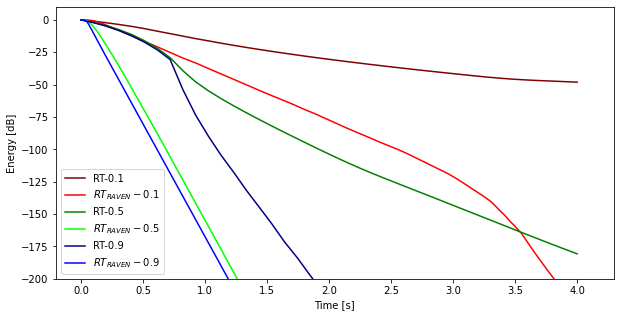

In [20]:
#t0 = np.linspace(0, 2, ISM_EDC.shape[0])
t1 = np.linspace(0, 4, RT_EDC.shape[0])
t2 = np.linspace(0, 4.10, RT_EDC_PANDAS.shape[0])

def get_color(x, i):
    c = [0, 0, 0, 1]
    c[x] = 1 * i
    return c

plt.figure(figsize=(10, 5))
for x in range(RT_EDC.shape[1]):
    plt.plot(t1, RT_EDC[:,x], color=get_color(x, 0.5), label=f'RT-{absorpt[x]}')
    plt.plot(t2, RT_EDC_PANDAS[f'a{absorpt[x]}-s0.5'], color=get_color(x, 1.0), label=f'$RT_{{RAVEN}}-{absorpt[x]}$')
    
plt.ylim(-200, 10)
plt.ylabel("Energy [dB]")
plt.legend()
plt.xlabel("Time [s]")
plt.savefig("compare-absorption.png")